# US Name
Model estimate Estimate sign of effect


# Description

None

# Metadata

- Key: 242_esg_metadata 
- Epic: Models
- US: Estimate sign of effect
- Task tag: #draft, #polymer, #sign-of-effect
- Analytics reports: 

# Input

## Table/file

**Name**

None

**Github**

- https://github.com/thomaspernet/esg_metadata/blob/master/02_data_analysis/01_model_train_evaluate/01_sign_of_effect/00_sign_of_effect_classification.md



# Connexion server

In [1]:
from awsPy.aws_authorization import aws_connector
from awsPy.aws_s3 import service_s3
from awsPy.aws_glue import service_glue
from pathlib import Path
import pandas as pd
import numpy as np
#import seaborn as sns
import os, shutil, json
import sys
import janitor

path = os.getcwd()
parent_path = str(Path(path).parent.parent.parent)


name_credential = 'financial_dep_SO2_accessKeys.csv'
region = 'eu-west-2'
bucket = 'datalake-london'
path_cred = "{0}/creds/{1}".format(parent_path, name_credential)

In [2]:
con = aws_connector.aws_instantiate(credential = path_cred,
                                       region = region)
client= con.client_boto()
s3 = service_s3.connect_S3(client = client,
                      bucket = bucket, verbose = False)
glue = service_glue.connect_glue(client = client) 

In [3]:
pandas_setting = True
if pandas_setting:
    #cm = sns.light_palette("green", as_cmap=True)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_colwidth', None)

In [4]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'


# Load tables

Since we load the data as a Pandas DataFrame, we want to pass the `dtypes`. We load the schema from Glue to guess the types

In [5]:
db = 'esg'
table = 'meta_analysis_esg_cfp'

In [6]:
dtypes = {}
schema = (glue.get_table_information(database = db,
                           table = table)
          ['Table']['StorageDescriptor']['Columns']
         )
for key, value in enumerate(schema):
    if value['Type'] in ['varchar(12)',
                         'varchar(3)',
                        'varchar(14)', 'varchar(11)']:
        format_ = 'string'
    elif value['Type'] in ['decimal(21,5)', 'double', 'bigint', 'int', 'float']:
        format_ = 'float'
    else:
        format_ = value['Type'] 
    dtypes.update(
        {value['Name']:format_}
    )

In [7]:
download_data = True
filename = 'df_{}'.format(table)
full_path_filename = 'SQL_OUTPUT_ATHENA/CSV/{}.csv'.format(filename)
path_local = os.path.join(str(Path(path).parent.parent.parent), 
                              "00_data_catalog/temporary_local_data")
df_path = os.path.join(path_local, filename + '.csv')
if download_data:
    
    s3 = service_s3.connect_S3(client = client,
                          bucket = bucket, verbose = False)
    query = """
    WITH test as (
  SELECT 
    *, concat(environmental,  social, governance) as filters
  FROM {}.{} 
  WHERE 
    first_date_of_observations IS NOT NULL 
    and last_date_of_observations IS NOT NULL 
    and adjusted_model != 'TO_REMOVE' 
) 
SELECT 
  filters, to_remove, test.id, image, row_id_excel, row_id_google_spreadsheet,
       table_refer, incremental_id, paper_name, publication_name,
       rank, sjr, sjr_best_quartile, h_index, total_docs_2020,
       total_docs_3years, total_refs, total_cites_3years,
       citable_docs_3years, cites_doc_2years, country,
       publication_year, publication_type, cnrs_ranking, peer_reviewed,
       study_focused_on_social_environmental_behaviour, type_of_data,
       first_date_of_observations,mid_year, last_date_of_observations,
       windows, adjusted_model_name,
       adjusted_model, dependent, adjusted_dependent, independent,
       adjusted_independent, 
       social,
       environmental,
       governance,
       financial_crisis,
       kyoto,
       regions,
       study_focusing_on_developing_or_developed_countries,
       lag,
       interaction_term, quadratic_term, n, r2, beta,
       sign_of_effect,
       adjusted_t_value,
       adjusted_standard_error,
       target,
       p_value_significant,
       weight
FROM 
  test 
  LEFT JOIN (
    SELECT 
      id, 
      COUNT(*) as weight 
    FROM 
      test 
    GROUP BY 
      id
  ) as c on test.id = c.id
  WHERE filters != 'TrueTrueTrue' and filters != 'FalseFalseFalse' and sjr IS NOT NULL

    """.format(db, table)
    try:
        df = (s3.run_query(
            query=query,
            database=db,
            s3_output='SQL_OUTPUT_ATHENA',
            filename=filename,  # Add filename to print dataframe
            destination_key='SQL_OUTPUT_ATHENA/CSV',  #Use it temporarily
            dtype = dtypes
        )
                )
    except:
        pass
    s3.download_file(
        key = full_path_filename
    )
    shutil.move(
        filename + '.csv',
        os.path.join(path_local, filename + '.csv')
    )
    s3.remove_file(full_path_filename)
df.head(2)

,filters,to_remove,id,image,row_id_excel,row_id_google_spreadsheet,table_refer,incremental_id,paper_name,publication_name,rank,sjr,sjr_best_quartile,h_index,total_docs_2020,total_docs_3years,total_refs,total_cites_3years,citable_docs_3years,cites_doc_2years,country,publication_year,publication_type,cnrs_ranking,peer_reviewed,study_focused_on_social_environmental_behaviour,type_of_data,first_date_of_observations,mid_year,last_date_of_observations,windows,adjusted_model_name,adjusted_model,dependent,adjusted_dependent,independent,adjusted_independent,social,environmental,governance,financial_crisis,kyoto,regions,study_focusing_on_developing_or_developed_countries,lag,interaction_term,quadratic_term,n,r2,beta,sign_of_effect,adjusted_t_value,adjusted_standard_error,target,p_value_significant,weight
0,NOYESNO,TO_KEEP,76,NaN,https://docs.google.com/spreadsheets/d/11A3l50yfiGxxRuyV-f3WV9Z-4DcsQLYW6XBl4a7U4bQ/edit#gid=18346659&range=B1000,https://docs.google.com/spreadsheets/d/1d66_CVtWni7wmKlIMcpaoanvT2ghmjbXARiHgnLWvUw/edit#gid=899172650&range=B513,table 9,512,Corporate social responsibility and corporate financial performance: Evidence from Korea,australian journal of management,11659,0.419,Q2,39.0,49,94.0,3718.0,182.0,94.0,2.06,United Kingdom,2010.0,Journal Article,0,YES,ENVIRONMENTAL AND SOCIAL,Panel data,2002,2005,2008,6,POOLED OLS,POOLED OLS,ROA,ROA,SW,SOCIAL,YES,NO,NO,NO,YES,ASIA AND PACIFIC,DEVELOPED,YES,NO,NO,1222.0,0.247,0.002,POSITIVE,0.001,3.38,SIGNIFICANT,1_PERCENT,12
1,NOYESNO,TO_KEEP,76,NaN,https://docs.google.com/spreadsheets/d/11A3l50yfiGxxRuyV-f3WV9Z-4DcsQLYW6XBl4a7U4bQ/edit#gid=18346659&range=B1000,https://docs.google.com/spreadsheets/d/1d66_CVtWni7wmKlIMcpaoanvT2ghmjbXARiHgnLWvUw/edit#gid=899172650&range=B514,table 9,513,Corporate social responsibility and corporate financial performance: Evidence from Korea,australian journal of management,11659,0.419,Q2,39.0,49,94.0,3718.0,182.0,94.0,2.06,United Kingdom,2010.0,Journal Article,0,YES,ENVIRONMENTAL AND SOCIAL,Panel data,2002,2005,2008,6,POOLED OLS,POOLED OLS,ROE,ROE,SW,SOCIAL,YES,NO,NO,NO,YES,ASIA AND PACIFIC,DEVELOPED,YES,NO,NO,1222.0,0.216,0.001,POSITIVE,0.000,2.78,SIGNIFICANT,1_PERCENT,12


In [8]:
df.isna().sum().sort_values().loc[lambda x: x> 0]

type_of_data                                             2
lag                                                      3
quadratic_term                                           3
interaction_term                                         3
n                                                        6
peer_reviewed                                            7
study_focusing_on_developing_or_developed_countries     10
adjusted_independent                                    20
adjusted_standard_error                                 79
r2                                                      92
adjusted_t_value                                       107
image                                                  151
dtype: int64

In [9]:
df['adjusted_model'].unique()

array(['POOLED OLS', 'FIXED EFFECT', 'OTHER', 'RANDOM EFFECT',
       'LAG DEPENDENT', 'INSTRUMENT', 'DIFF IN DIFF'], dtype=object)

In [10]:
df['target'].value_counts()

SIGNIFICANT        317
NOT_SIGNIFICANT    271
Name: target, dtype: int64

In [11]:
pd.DataFrame(schema)

,Name,Type,Comment
0,to_remove,string,to remove
1,id,string,paper ID
2,image,string,Link row data image
3,row_id_excel,string,link to original row
4,row_id_google_spreadsheet,string,Google spreadsheet link to raw data
5,table_refer,string,table number in the paper
6,incremental_id,string,row id
7,paper_name,string,Paper name
8,publication_name,string,publication name
9,rank,bigint,journal rank


## unbalanced ID

In [12]:
df['weight'].describe()

count    588.000000
mean      21.302721
std       20.721324
min        1.000000
25%        8.000000
50%       12.000000
75%       32.000000
max       70.000000
Name: weight, dtype: float64

<AxesSubplot:ylabel='Frequency'>

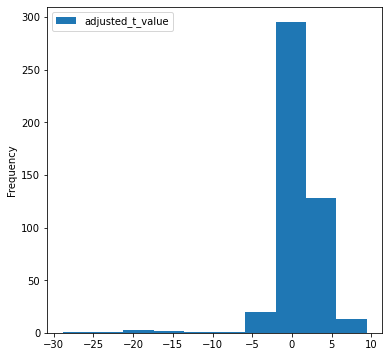

In [13]:
(
    df
    .loc[lambda x: x['adjusted_t_value'] <=10 ]
    .reindex(columns = ['adjusted_t_value'])
    .plot
    .hist(10, figsize= (6,6))
)

In [14]:
df['adjusted_t_value'].describe()

count      481.000000
mean        33.021911
std        513.376096
min        -28.897000
25%         -0.169000
50%          0.654000
75%          2.214000
max      10307.000000
Name: adjusted_t_value, dtype: float64

## Schema Latex table

To rename a variable, please use the following template:

```
{
    'old':'XX',
    'new':'XX_1'
    }
```

if you need to pass a latex format with `\`, you need to duplicate it for instance, `\text` becomes `\\text:

```
{
    'old':'working\_capital\_i',
    'new':'\\text{working capital}_i'
    }
```

Then add it to the key `to_rename`

In [15]:
add_to_dic = False
if add_to_dic:
    if os.path.exists("schema_table.json"):
        os.remove("schema_table.json")
    data = {'to_rename':[], 'to_remove':[]}
    dic_rename = [
        {
        'old':'working\_capital\_i',
        'new':'\\text{working capital}_i'
        },
    ]

    data['to_rename'].extend(dic_rename)
    with open('schema_table.json', 'w') as outfile:
        json.dump(data, outfile)

In [16]:
sys.path.append(os.path.join(parent_path, 'utils'))
import latex.latex_beautify as lb
#%load_ext autoreload
#%autoreload 2

In [17]:
#!conda install -c conda-forge r-lmtest -y

In [18]:
options(warn=-1)
library(tidyverse)
library("sandwich")
library("lmtest")
#library(lfe)
#library(lazyeval)
#library(nnet)
library('progress')
path = "../../../utils/latex/table_golatex.R"
source(path)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Please cite as: 

 Hlavac, Marek (2018). stargazer: Well-Formatted Regression and Summary Statistics Tables.
 R package version 5.2.2. https://CRAN.R-project.org/package=stargazer 



In [19]:
%get df_path
df_final <- read_csv(df_path) %>%
mutate_if(is.character, as.factor) %>%
mutate(
    sign_of_effect = relevel(sign_of_effect, ref='NEGATIVE'),
    adjusted_model = relevel(adjusted_model, ref='OTHER'),
    adjusted_dependent = relevel(adjusted_dependent, ref='OTHER'),
      id = as.factor(id),
    governance = relevel(as.factor(governance), ref = 'NO'),
    social = relevel(as.factor(social), ref = 'NO'),
    environmental =relevel(as.factor(environmental), ref = 'NO'),
    financial_crisis =relevel(as.factor(financial_crisis), ref = 'NO'),
    kyoto =relevel(as.factor(kyoto), ref = 'NO'),
    target =relevel(as.factor(target), ref = 'NOT_SIGNIFICANT'),
    study_focusing_on_developing_or_developed_countries =relevel(
        as.factor(study_focusing_on_developing_or_developed_countries), ref = 'WORLDWIDE'),
    regions =relevel(as.factor(regions), ref = 'WORLDWIDE'),
    cnrs_ranking =relevel(as.factor(cnrs_ranking), ref = '0'),
)

Parsed with column specification:
cols(
  .default = col_character(),
  id = col_double(),
  incremental_id = col_double(),
  rank = col_double(),
  sjr = col_double(),
  h_index = col_double(),
  total_docs_2020 = col_double(),
  total_docs_3years = col_double(),
  total_refs = col_double(),
  total_cites_3years = col_double(),
  citable_docs_3years = col_double(),
  cites_doc_2years = col_double(),
  publication_year = col_double(),
  cnrs_ranking = col_double(),
  first_date_of_observations = col_double(),
  mid_year = col_double(),
  last_date_of_observations = col_double(),
  windows = col_double(),
  n = col_double(),
  r2 = col_double(),
  beta = col_double()
  # ... with 3 more columns
)
See spec(...) for full column specifications.


In [20]:
glimpse(df_final)

Observations: 588
Variables: 56
$ filters                                             <fct> NOYESNO, NOYESNO,…
$ to_remove                                           <fct> TO_KEEP, TO_KEEP,…
$ id                                                  <fct> 76, 76, 76, 78, 7…
$ image                                               <fct> NA, NA, NA, https…
$ row_id_excel                                        <fct> https://docs.goog…
$ row_id_google_spreadsheet                           <fct> https://docs.goog…
$ table_refer                                         <fct> table 9, table 9,…
$ incremental_id                                      <dbl> 512, 513, 514, 51…
$ paper_name                                          <fct> Corporate social …
$ publication_name                                    <fct> australian journa…
$ rank                                                <dbl> 11659, 11659, 116…
$ sjr                                                 <dbl> 0.419, 0.419, 0.4…
$ sjr_best_quartile 

In [21]:
transpose(df_final %>% 
    select_if(function(x) any(is.na(x))) %>% 
    summarise_each(funs(sum(is.na(.)))))

[[1]]
[[1]]$image
[1] 151

[[1]]$peer_reviewed
[1] 7

[[1]]$type_of_data
[1] 2

[[1]]$adjusted_independent
[1] 20

[[1]]$study_focusing_on_developing_or_developed_countries
[1] 10

[[1]]$lag
[1] 3

[[1]]$interaction_term
[1] 3

[[1]]$quadratic_term
[1] 3

[[1]]$n
[1] 6

[[1]]$r2
[1] 92

[[1]]$adjusted_t_value
[1] 107

[[1]]$adjusted_standard_error
[1] 79

GLM does not clustered the standard error so, we compute it by hand

In [22]:
se_robust <- function(x)
  coeftest(x, vcov. = sandwich::sandwich
          )[, 2]
se_robust_clustered <- function(x)
  coeftest(x,
         vcov. = vcovCL(t_2, cluster = df_final %>% filter(adjusted_model != 'TO_REMOVE') %>% select(id), type = "HC0")
        )[, 2]

# Table 1: Probit

$$
\mathrm{P}\left(\text { Significant }_{\mathrm{ib}}=\mathrm{significant}\right)=\mathrm{\beta}_{0} + 
\mathrm{\beta}_{1}\text { ESG }_{\mathrm{ib}}+ 
\mathrm{\beta}_{2}\text { Kyoto }_{\mathrm{i}} +
\mathrm{\beta}_{3}\text { Financial crisis }_{\mathrm{i}} +
\mathrm{\beta}_{4}\text { Publication year }_{\mathrm{i}} + 
\mathrm{\beta}_{5}\text { windows }_{\mathrm{i}} +
\mathrm{\beta}_{6}\text { mid-year }_{\mathrm{i}} +
\mathrm{\beta}_{7}\text { region }_{\mathrm{ib}}
+\epsilon _{\mathrm{ib}}
$$

- robust standard error
- Cannot compute clustered standard error if we add features without variation among the c luster (i.e `n`, or journal information)

## Variable construction


* Significant: If in the table, p-value below .1, then significant else not significant
* The variable adjusted_independent is too imbalanced, and we are interested in only:
  * SOCIAL
  * ENVIRONMENTAL
  * GOVERNANCE
* So need to create three underlying dummy variables: rules below
  * Source low-level variable: https://docs.google.com/spreadsheets/d/1d66_CVtWni7wmKlIMcpaoanvT2ghmjbXARiHgnLWvUw/edit#gid=146632716&range=B126
  * SOCIAL if adjusted_independent : 
    * ENVIRONMENTAL AND SOCIAL
    * SOCIAL
    * CSP
    * CSR
    * ENVIRONMENTAL, SOCIAL and GOVERNANCE
  * ENVIRONMENTAL if adjusted_independent :
    * ENVIRONMENTAL
    * ENVIRONMENTAL AND SOCIAL
    * ENVIRONMENTAL, SOCIAL and GOVERNANCE
  * GOVERNANCE if adjusted_independent :
    * GOVERNANCE
    * ENVIRONMENTAL, SOCIAL and GOVERNANCE
- adjusted_model: https://docs.google.com/spreadsheets/d/1d66_CVtWni7wmKlIMcpaoanvT2ghmjbXARiHgnLWvUw/edit#gid=793443705&range=B34
- adjusted_dependent: https://docs.google.com/spreadsheets/d/1d66_CVtWni7wmKlIMcpaoanvT2ghmjbXARiHgnLWvUw/edit#gid=450174628&range=B59
- Region:
```
CASE WHEN regions_of_selected_firms in (
        'Cameroon', 'Egypt', 'Libya', 'Morocco', 
        'Nigeria'
      ) THEN 'AFRICA' WHEN regions_of_selected_firms in ('GCC countries') THEN 'ARAB WORLD' WHEN regions_of_selected_firms in (
        'India', 'Indonesia', 'Taiwan', 'Vietnam', 
        'Australia', 'China', 'Iran', 'Malaysia', 
        'Pakistan', 'South Korea', 'Bangladesh'
      ) THEN 'ASIA AND PACIFIC' WHEN regions_of_selected_firms in (
        'Spain', '20 European countries', 
        'United Kingdom', 'France', 'Germany, Italy, the Netherlands and United Kingdom', 
        'Turkey', 'UK'
      ) THEN 'EUROPE' WHEN regions_of_selected_firms in ('Latin America', 'Brazil') THEN 'LATIN AMERICA' WHEN regions_of_selected_firms in ('USA', 'US', 'U.S.', 'Canada') THEN 'NORTH AMERICA' ELSE 'WORLDWIDE' END AS regions
```
- Kyoto first_date_of_observations >= 1997 THEN TRUE ELSE FALSE ,
- Financial crisis first_date_of_observations >= 2009 THEN TRUE ELSE FALSE 
- windows: last_date_of_observations - first_date_of_observations
- mid-year: last_date_of_observations - (windows/2)


## note about Probit 

TO estimate a probit, use `probit` link function.  For logistic regression, use `binomial`

- Reason Probit instead of Logit
    - [What is the Difference Between Logit and Probit Models?](https://tutorials.methodsconsultants.com/posts/what-is-the-difference-between-logit-and-probit-models/)

Logit and probit differ in how they define $f(∗)$. The logit model uses something called the cumulative distribution function of the logistic distribution. The probit model uses something called the cumulative distribution function of the standard normal distribution to define $f(∗)$.

Probit models can be generalized to account for non-constant error variances in more advanced econometric settings (known as heteroskedastic probit models)

## How to read

**Comparison group**

- Always `OTHER`
- Target: `SIGNIFICANT`
- regions: `WORLDWIDE`
- cnrs_ranking: `0`

**Odd ratio**

- Categorical:
    - Keeping all other variables constant, if the analysis uses FIXED EFFECT model, there are 2.71 times more likely to stay in the NEGATIVE sign category as compared to the OTHER model category. The coefficient, however, is not significant. (Col 1)
- Continuous:
    - Keeping all other variables constant, if the SJR score increases one unit, there is 1.003 times more likely to stay in the POSITIVE sign category as compared to the OTHER model category y (the risk or odds is .2% higher). The coefficient is significant.
    
Here, OTHER means insignificant

In [23]:
### Baseline SJR
t_0 <- glm(target ~ environmental
           + adjusted_model  
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + sjr,
           data = df_final ,
           binomial(link = "probit")
          )
t_0.rrr <- exp(coef(t_0))
t_1 <- glm(target ~ social
           + adjusted_model    
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + sjr,
           data = df_final , binomial(link = "probit"))
t_1.rrr <- exp(coef(t_1))
t_2 <- glm(target ~ governance
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + sjr,
           data = df_final , binomial(link = "probit"))
t_2.rrr <- exp(coef(t_2))
### Econometrics control
t_3 <- glm(target ~ environmental
           + adjusted_model  
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + sjr
           + lag
           + interaction_term
           + quadratic_term,
           data = df_final ,
           binomial(link = "probit")
          )
t_3.rrr <- exp(coef(t_3))
t_4 <- glm(target ~ social
           + adjusted_model    
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + sjr
           + lag
           + interaction_term
           + quadratic_term,
           data = df_final , binomial(link = "probit"))
t_4.rrr <- exp(coef(t_4))
t_5 <- glm(target ~ governance
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + sjr
           + lag
           + interaction_term
           + quadratic_term,
           data = df_final , binomial(link = "probit"))
t_5.rrr <- exp(coef(t_5))

list_final = list(t_0, t_1, t_2, t_3, t_4, t_5)
list_final.rrr = list(t_0.rrr,t_1.rrr ,t_2.rrr,t_3.rrr,t_4.rrr,t_5.rrr)
stargazer(list_final, type = "text", 
  se = lapply(list_final,
              se_robust),
          coef=list_final.rrr,
          style = "qje")


                                                   target                        
                              (1)      (2)      (3)      (4)      (5)      (6)   
---------------------------------------------------------------------------------
environmentalYES            1.152***                   1.159***                  
                            (0.156)                    (0.162)                   
                                                                                 
socialYES                            1.002***                   1.012***         
                                     (0.135)                    (0.136)          
                                                                                 
governanceYES                                 0.990***                   0.960***
                                              (0.260)                    (0.265) 
                                                                                 
adjusted_modelD

In [24]:
### Baseline SJR
t_0 <- glm(target ~ environmental
           + adjusted_model  
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + cnrs_ranking,
           data = df_final ,
           binomial(link = "probit")
          )
t_0.rrr <- exp(coef(t_0))
t_1 <- glm(target ~ social
           + adjusted_model    
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + cnrs_ranking,
           data = df_final , binomial(link = "probit"))
t_1.rrr <- exp(coef(t_1))
t_2 <- glm(target ~ governance
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + cnrs_ranking,
           data = df_final , binomial(link = "probit"))
t_2.rrr <- exp(coef(t_2))
### Econometrics control
t_3 <- glm(target ~ environmental
           + adjusted_model  
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + cnrs_ranking
           + lag
           + interaction_term
           + quadratic_term,
           data = df_final ,
           binomial(link = "probit")
          )
t_3.rrr <- exp(coef(t_3))
t_4 <- glm(target ~ social
           + adjusted_model    
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + cnrs_ranking
           + lag
           + interaction_term
           + quadratic_term,
           data = df_final , binomial(link = "probit"))
t_4.rrr <- exp(coef(t_4))
t_5 <- glm(target ~ governance
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + cnrs_ranking
           + lag
           + interaction_term
           + quadratic_term,
           data = df_final , binomial(link = "probit"))
t_5.rrr <- exp(coef(t_5))

list_final = list(t_0, t_1, t_2, t_3, t_4, t_5)
list_final.rrr = list(t_0.rrr,t_1.rrr ,t_2.rrr,t_3.rrr,t_4.rrr,t_5.rrr)
stargazer(list_final, type = "text", 
  se = lapply(list_final,
              se_robust),
          coef=list_final.rrr,
          style = "qje")


                                                   target                        
                              (1)      (2)      (3)      (4)      (5)      (6)   
---------------------------------------------------------------------------------
environmentalYES            1.116***                   1.146***                  
                            (0.156)                    (0.161)                   
                                                                                 
socialYES                            1.017***                   1.011***         
                                     (0.133)                    (0.134)          
                                                                                 
governanceYES                                 1.023***                   1.011***
                                              (0.264)                    (0.267) 
                                                                                 
adjusted_modelD

## Model OLS: 

$$
 \text{T-value}=\mathrm{\beta}_{0} + 
\mathrm{\beta}_{1}\text { ESG }_{\mathrm{ib}}+ 
\mathrm{\beta}_{2}\text { Kyoto }_{\mathrm{i}} +
\mathrm{\beta}_{3}\text { Financial crisis }_{\mathrm{i}} +
\mathrm{\beta}_{4}\text { Publication year }_{\mathrm{i}} + 
\mathrm{\beta}_{5}\text { windows }_{\mathrm{i}} +
\mathrm{\beta}_{6}\text { mid-year }_{\mathrm{i}} +
\mathrm{\beta}_{7}\text { region }_{\mathrm{ib}}
+\epsilon _{\mathrm{ib}}
$$

### Computation t-value

* construct should_t_value   equals to “TO_CHECK” → if test_standard_error   = “TO_CHECK” and adjusted_model  is not PANEL or POOLED (use panel because panel use clustered/robust standard error no direct computation), then check if switch standard error and t-stat, so use column sr has t-stat and compare with critical value. If match critical value, and equals to stars  then OK, else “TO_CHECK”
* Construct adjusted_standard_error : if test_standard_error  is OK and should_t_value  is NO_NEED_TO_CHECK then use sr , else leave blank
* Construct **adjusted_t_value**: 
  * ⚠️ critical value (the raw data has a column for the t_value which is similar, but the variable adjusted_t_value is reconstructed based on known t_value or in case of unknown t_value then from standard error or p-value: 
    * If test_t_value is equals to TO_CHECK or OK then use t_value ← We use the value reported in the paper, not the one reconstructed
    * ELSE if test_standard_error is equal to NO_SE and test_p_value is equal to OK then we can compute the critical value using the t-inverse function. 
      * Ex: round(T.INV(1-X114, I114) where X114 is the p-value, so we want to get the right tail. If p-value is .05, the the right tail is .95.
    * ELSE beta / standard error 
    * Note, if critical value cannot be computed, it is because of one of the following reason
      *  p-value is 0, then cannot compute the critical value
      * standard error is 0, cannot divide by 0
      * missing standard error, t-value or p-value
      
- Remove 10 outliers -> critical value more than 1K -> high leverage and does not represent the true data
- Standard error robust

Model 1: No absolute value

Interested in the magnitude of the t-student critical value

In [25]:
### Baseline SJR
t_0 <- glm(adjusted_t_value ~ environmental
           + adjusted_model  
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + sjr,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity))

t_1 <- glm(adjusted_t_value ~ social
           + adjusted_model    
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + sjr,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity))

t_2 <- glm(adjusted_t_value ~ governance
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + sjr,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity))

### Econometrics control
t_3 <- glm(adjusted_t_value ~ environmental
           + adjusted_model  
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + sjr
           + lag
           + interaction_term
           + quadratic_term,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity))

t_4 <- glm(adjusted_t_value ~ social
           + adjusted_model    
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + sjr
           + lag
           + interaction_term
           + quadratic_term,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity))

t_5 <- glm(adjusted_t_value ~ governance
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + sjr
           + lag
           + interaction_term
           + quadratic_term,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity))


list_final = list(t_0, t_1, t_2, t_3, t_4, t_5)
stargazer(list_final, type = "text", 
  se = lapply(list_final,
              se_robust),
          coef=list_final.rrr,
          style = "qje")


                                                    adjusted_t_value                         
                               (1)        (2)        (3)        (4)        (5)        (6)    
---------------------------------------------------------------------------------------------
environmentalYES             1.116***                         1.146***                       
                             (0.312)                          (0.323)                        
                                                                                             
socialYES                               1.017***                         1.011***            
                                        (0.296)                          (0.298)             
                                                                                             
governanceYES                                       1.023                            1.011   
                                                   (0.642) 

In [26]:
### Baseline SJR
t_0 <- glm(adjusted_t_value ~ environmental
           + adjusted_model  
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + cnrs_ranking,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity))

t_1 <- glm(adjusted_t_value ~ social
           + adjusted_model    
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + cnrs_ranking,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity))

t_2 <- glm(adjusted_t_value ~ governance
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + cnrs_ranking,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity))

### Econometrics control
t_3 <- glm(adjusted_t_value ~ environmental
           + adjusted_model  
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + cnrs_ranking
           + lag
           + interaction_term
           + quadratic_term,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity))

t_4 <- glm(adjusted_t_value ~ social
           + adjusted_model    
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + cnrs_ranking
           + lag
           + interaction_term
           + quadratic_term,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity))

t_5 <- glm(adjusted_t_value ~ governance
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + cnrs_ranking
           + lag
           + interaction_term
           + quadratic_term,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity))


list_final = list(t_0, t_1, t_2, t_3, t_4, t_5)
stargazer(list_final, type = "text", 
  se = lapply(list_final,
              se_robust),
          coef=list_final.rrr,
          style = "qje")


                                                    adjusted_t_value                         
                               (1)        (2)        (3)        (4)        (5)        (6)    
---------------------------------------------------------------------------------------------
environmentalYES             1.116***                         1.146***                       
                             (0.272)                          (0.289)                        
                                                                                             
socialYES                               1.017***                         1.011***            
                                        (0.276)                          (0.287)             
                                                                                             
governanceYES                                       1.023                            1.011   
                                                   (0.636) 

Model 2: absolute value

Interested in the factors leading to larger t-student critical value, hence significant coefficient

In [27]:
### Baseline SJR
t_0 <- glm(abs(adjusted_t_value) ~ environmental
           + adjusted_model  
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + sjr,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity))

t_1 <- glm(abs(adjusted_t_value) ~ social
           + adjusted_model    
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + sjr,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity))

t_2 <- glm(abs(adjusted_t_value) ~ governance
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + sjr,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity))

### Econometrics control
t_3 <- glm(abs(adjusted_t_value) ~ environmental
           + adjusted_model  
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + sjr
           + lag
           + interaction_term
           + quadratic_term,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity))

t_4 <- glm(abs(adjusted_t_value) ~ social
           + adjusted_model    
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + sjr
           + lag
           + interaction_term
           + quadratic_term,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity))

t_5 <- glm(abs(adjusted_t_value) ~ governance
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + sjr
           + lag
           + interaction_term
           + quadratic_term,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity))


list_final = list(t_0, t_1, t_2, t_3, t_4, t_5)
stargazer(list_final, type = "text", 
  se = lapply(list_final,
              se_robust),
          coef=list_final.rrr,
          style = "qje")


                                                  abs(adjusted_t_value)                      
                               (1)        (2)        (3)        (4)        (5)        (6)    
---------------------------------------------------------------------------------------------
environmentalYES             1.116***                         1.146***                       
                             (0.252)                          (0.267)                        
                                                                                             
socialYES                               1.017***                         1.011***            
                                        (0.245)                          (0.252)             
                                                                                             
governanceYES                                      1.023**                          1.011**  
                                                   (0.487) 

In [28]:
### Baseline SJR
t_0 <- glm(abs(adjusted_t_value) ~ environmental
           + adjusted_model  
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + cnrs_ranking,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity))

t_1 <- glm(abs(adjusted_t_value) ~ social
           + adjusted_model    
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + cnrs_ranking,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity))

t_2 <- glm(abs(adjusted_t_value) ~ governance
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + cnrs_ranking,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity))

### Econometrics control
t_3 <- glm(abs(adjusted_t_value) ~ environmental
           + adjusted_model  
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + cnrs_ranking
           + lag
           + interaction_term
           + quadratic_term,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity))

t_4 <- glm(abs(adjusted_t_value) ~ social
           + adjusted_model    
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + cnrs_ranking
           + lag
           + interaction_term
           + quadratic_term,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity))

t_5 <- glm(abs(adjusted_t_value) ~ governance
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + cnrs_ranking
           + lag
           + interaction_term
           + quadratic_term,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity))


list_final = list(t_0, t_1, t_2, t_3, t_4, t_5)
stargazer(list_final, type = "text", 
  se = lapply(list_final,
              se_robust),
          coef=list_final.rrr,
          style = "qje")


                                                  abs(adjusted_t_value)                      
                               (1)        (2)        (3)        (4)        (5)        (6)    
---------------------------------------------------------------------------------------------
environmentalYES             1.116***                         1.146***                       
                             (0.227)                          (0.243)                        
                                                                                             
socialYES                               1.017***                         1.011***            
                                        (0.231)                          (0.241)             
                                                                                             
governanceYES                                      1.023**                          1.011**  
                                                   (0.468) 

# Statistics

## Target

In [29]:
(
    pd.concat(
        [
            (df.groupby("environmental").agg({"target": "value_counts"}).unstack(0)).rename(columns = {'target':'environment'}),
            (df.groupby("social").agg({"target": "value_counts"}).unstack(0)).rename(columns = {'target':'social'}),
            (df.groupby("governance").agg({"target": "value_counts"}).unstack(0)).rename(columns = {'target':'governance'}),
        ],
        axis=1,
    )
    .T
    .reset_index()
    .rename(columns = {'environmental':'is_dummy', 'level_0':'origin'})
    .set_index(['origin','is_dummy'])
    .assign(pct_significant = lambda x: x[('SIGNIFICANT')]/x.sum(axis= 1))
    #
    #
)



target                NOT_SIGNIFICANT  SIGNIFICANT  pct_significant
origin      is_dummy                                               
environment NO                    215          248         0.535637
            YES                    56           69         0.552000
social      NO                     89           99         0.526596
            YES                   182          218         0.545000
governance  NO                    254          302         0.543165
            YES                    17           15         0.468750

In [30]:
(
    df
    .groupby('adjusted_model')
    .agg(
    {
        'target':'value_counts'
    })
    .unstack(-1)
    .assign(pct_significant = lambda x: x[('target','SIGNIFICANT')]/x.sum(axis= 1))
)

target             pct_significant
target         NOT_SIGNIFICANT SIGNIFICANT                
adjusted_model                                            
DIFF IN DIFF                 8           4        0.333333
FIXED EFFECT               106         141        0.570850
INSTRUMENT                   9           7        0.437500
LAG DEPENDENT               34           8        0.190476
OTHER                       37          48        0.564706
POOLED OLS                  68          86        0.558442
RANDOM EFFECT                9          23        0.718750

In [31]:
(
    pd.concat(
        [
            (df.groupby("kyoto").agg({"target": "value_counts"}).unstack(0)).rename(columns = {'target':'kyoto'}),
            (df.groupby("financial_crisis").agg({"target": "value_counts"}).unstack(0)).rename(columns = {'target':'financial_crisis'}),
            #(df.groupby("governance").agg({"target": "value_counts"}).unstack(0)).rename(columns = {'target':'governance'}),
        ],
        axis=1,
    )
    .T
    .reset_index()
    .rename(columns = {'kyoto':'is_dummy', 'level_0':'origin'})
    .set_index(['origin','is_dummy'])
    .assign(pct_significant = lambda x: x[('SIGNIFICANT')]/x.sum(axis= 1))
)

target                     NOT_SIGNIFICANT  SIGNIFICANT  pct_significant
origin           is_dummy                                               
kyoto            NO                     65           65         0.500000
                 YES                   206          252         0.550218
financial_crisis NO                    261          257         0.496139
                 YES                    10           60         0.857143

## Papers

In [32]:
(
    df
    .groupby('target')
    .agg(
    {
        'windows':'describe'
    })
)

windows                                               
                  count      mean       std  min  25%  50%   75%   max
target                                                                
NOT_SIGNIFICANT   271.0  8.557196  4.589385  0.0  5.0  9.0  13.0  28.0
SIGNIFICANT       317.0  7.419558  4.600220  0.0  4.0  6.0  10.0  28.0

- lag
- interaction_term
- quadratic_term

In [33]:
(
    pd.concat(
        [
            (df.groupby("lag").agg({"target": "value_counts"}).unstack(0)).rename(columns = {'target':'lag'}),
            (df.groupby("interaction_term").agg({"target": "value_counts"}).unstack(0)).rename(columns = {'target':'interaction_term'}),
            (df.groupby("quadratic_term").agg({"target": "value_counts"}).unstack(0)).rename(columns = {'target':'quadratic_term'}),
        ],
        axis=1,
    )
    .T
    .reset_index()
    .rename(columns = {'lag':'is_dummy', 'level_0':'origin'})
    .set_index(['origin','is_dummy'])
    .assign(pct_significant = lambda x: x[('SIGNIFICANT')]/x.sum(axis= 1))
)

target                     NOT_SIGNIFICANT  SIGNIFICANT  pct_significant
origin           is_dummy                                               
lag              NO                    216          272         0.557377
                 YES                    55           42         0.432990
interaction_term NO                    197          255         0.564159
                 NO                     31            4         0.114286
                 YES                    43           55         0.561224
quadratic_term   NO                    266          305         0.534151
                 YES                     5            9         0.642857

##  Region

- regions
- study_focusing_on_developing_or_developed_countries

Comparison group: "WORLDWIDE"

In [34]:
(
    df
    .groupby('regions')
    .agg(
    {
        'target':'value_counts'
    })
    .unstack(-1)
    .assign(pct_significant = lambda x: x[('target','SIGNIFICANT')]/x.sum(axis= 1))
)

target             pct_significant
target           NOT_SIGNIFICANT SIGNIFICANT                
regions                                                     
AFRICA                         4           3        0.428571
ASIA AND PACIFIC              33          51        0.607143
EUROPE                        25          35        0.583333
LATIN AMERICA                  7          13        0.650000
NORTH AMERICA                 46          74        0.616667
WORLDWIDE                    156         141        0.474747

In [35]:
(
    df
    .groupby('study_focusing_on_developing_or_developed_countries')
    .agg(
    {
        'target':'value_counts'
    })
    .unstack(-1)
    .assign(pct_significant = lambda x: x[('target','SIGNIFICANT')]/x.sum(axis= 1))
)

target  \
target                                              NOT_SIGNIFICANT   
study_focusing_on_developing_or_developed_countries                   
DEVELOPED                                                        80   
DEVELOPING                                                       34   
WORLDWIDE                                                       151   

                                                                 \
target                                              SIGNIFICANT   
study_focusing_on_developing_or_developed_countries               
DEVELOPED                                                   114   
DEVELOPING                                                   66   
WORLDWIDE                                                   133   

                                                    pct_significant  
target                                                               
study_focusing_on_developing_or_developed_countries                  
DEVELOPED                                                  0.587629  
DEVELOPING                                                 0.660000  
WORLDWIDE                                                  0.468310

## Journal

- sjr 
- sjr_best_quartile: Q1
- cnrs_ranking: 0
- h_index

In [36]:
(
    df
    .groupby('target')
    .agg(
    {
        'sjr':'describe'
    })
    #.unstack(-1)
    #.assign(pct_significant = lambda x: x[('target','SIGNIFICANT')]/x.sum(axis= 1))
)

sjr                                                        
                 count      mean       std    min    25%    50%    75%     max
target                                                                        
NOT_SIGNIFICANT  271.0  2.619494  2.614425  0.327  1.339  1.937  3.328  11.193
SIGNIFICANT      317.0  2.676085  2.933672  0.314  1.049  1.734  2.321  11.193

In [37]:
(
    df
    .groupby('sjr_best_quartile')
    .agg(
    {
        'target':'value_counts'
    })
    .unstack(-1)
    .assign(pct_significant = lambda x: x[('target','SIGNIFICANT')]/x.sum(axis= 1))
)

target             pct_significant
target            NOT_SIGNIFICANT SIGNIFICANT                
sjr_best_quartile                                            
Q1                          222.0       256.0        0.535565
Q2                           49.0        58.0        0.542056
Q3                            NaN         3.0        1.000000

In [38]:
(
    df
    .groupby('cnrs_ranking')
    .agg(
    {
        'target':'value_counts'
    })
    .unstack(-1)
    .assign(pct_significant = lambda x: x[('target','SIGNIFICANT')]/x.sum(axis= 1))
)

target             pct_significant
target       NOT_SIGNIFICANT SIGNIFICANT                
cnrs_ranking                                            
0                        112         123        0.523404
1                         29          53        0.646341
2                         99          98        0.497462
3                         17          23        0.575000
4                         14          20        0.588235

In [39]:
(
    df
    .groupby('target')
    .agg(
    {
        'h_index':'describe'
    })
    #.unstack(-1)
    #.assign(pct_significant = lambda x: x[('target','SIGNIFICANT')]/x.sum(axis= 1))
)

h_index                                                   \
                  count        mean        std   min   25%    50%    75%   
target                                                                     
NOT_SIGNIFICANT   271.0  133.280443  76.231487  17.0  73.0  103.0  199.0   
SIGNIFICANT       317.0  131.479495  81.904837  16.0  68.0   85.0  199.0   

                        
                   max  
target                  
NOT_SIGNIFICANT  318.0  
SIGNIFICANT      318.0

# Generate reports

In [40]:
import os, time, shutil, urllib, ipykernel, json
from pathlib import Path
from notebook import notebookapp
import sys
path = os.getcwd()
parent_path = str(Path(path).parent.parent.parent)
sys.path.append(os.path.join(parent_path, 'utils'))
import make_toc
import create_report

In [41]:
name_json = 'parameters_ETL_esg_metadata.json'
path_json = os.path.join(str(Path(path).parent.parent), 'utils',name_json)

In [42]:
create_report.create_report(extension = "html", keep_code = True, notebookname = "00_sign_of_effect_classification.ipynb")

Report Available at this adress:
 /home/ubuntu/esg_metadata/02_data_analysis/01_model_train_evaluate/01_sign_of_effect/Reports/00_sign_of_effect_classification.html


In [43]:
### Update TOC in Github
for p in [parent_path,
          str(Path(path).parent),
          #os.path.join(str(Path(path).parent), "00_download_data_from"),
          #os.path.join(str(Path(path).parent.parent), "02_data_analysis"),
          #os.path.join(str(Path(path).parent.parent), "02_data_analysis", "00_statistical_exploration"),
          #os.path.join(str(Path(path).parent.parent), "02_data_analysis", "01_model_estimation"),
         ]:
    try:
        os.remove(os.path.join(p, 'README.md'))
    except:
        pass
    path_parameter = os.path.join(parent_path,'utils', name_json)
    md_lines =  make_toc.create_index(cwd = p, path_parameter = path_parameter)
    md_out_fn = os.path.join(p,'README.md')
    
    if p == parent_path:
    
        make_toc.replace_index(md_out_fn, md_lines, Header = os.path.basename(p).replace('_', ' '), add_description = True, path_parameter = path_parameter)
    else:
        make_toc.replace_index(md_out_fn, md_lines, Header = os.path.basename(p).replace('_', ' '), add_description = False)